# MLP Character-Level Language Model
Based on makemore part 2: https://www.youtube.com/watch?v=TCH_1BHY58I&ab_channel=AndrejKarpathy

### Dependencies & Data

In [379]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import math
from prettytable import PrettyTable

In [2]:
# DATA 
words = open('../makemore_data/names.txt', 'r').read().splitlines()

print(words[:10])
print(f"length {len(words)}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
length 32033


In [3]:
chars = sorted(list(set(''.join(words)))) 
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##just one special character for start and end of word
itos = {i:s for s, i in stoi.items()}

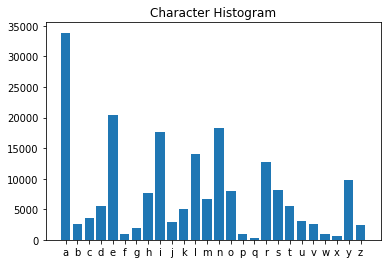

In [4]:
corpus = ''.join(words)
count_letters = dict()

for c in chars:
    count_letters[c] = corpus.count(c)

plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

In [456]:
def xavier_init(n_inputs, n_neurons, generator=None):
    lower, upper = -(1.0 / math.sqrt(n_inputs)), (1.0 / math.sqrt(n_inputs))
    return lower + torch.rand((n_inputs, n_neurons), requires_grad=True, generator=generator) * (upper - lower)

xavier_init(1, 27, generator=g)

tensor([[-0.8840, -0.1388, -0.4435,  0.9288, -0.4744, -0.4551,  0.6283, -0.7708,
          0.7662, -0.2287, -0.7284,  0.8506, -0.3573, -0.1984, -0.2393, -0.1488,
          0.5148, -0.3087, -0.6113, -0.5030,  0.9854,  0.6775,  0.6018, -0.8697,
          0.6489,  0.4489,  0.3929]], grad_fn=<AddBackward0>)

# N-Gram model & training pipeline

In [301]:
def words_to_data(words, block_size=3):
    """
    Takes words list and breaks into training samples such that
    block_size characters are used to predict the following character.
    Returns X, Y (inputs and labels), where each sample in X is a tensor containing block_size elements
    and each sample in Y is a tensor containing one element.
    """
    alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    stoi = {s:i+1 for i, s in enumerate(alph)} ##create dictionary mapping from char to int
    stoi['.'] = 0 ##just one special character for start and end of word

    # Data
    ## block_size = context length: how many chars do we use to predict the next?
    X, Y = [], []
    for w in words:

        context = [0] * block_size #start with padded context of just 0 tokes ('.')
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop the context vector and append the new index
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    n_samples = X.shape[0]
    print(f"{ n_samples = }")

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [473]:
class MLP:

    def __init__(self, block_size):
        """
        An instance of an MLP where 'block_size' defines the number of characters used 
        to predict the next character (the block size or context).
        """
        self.n_inputs = block_size ##the number of inputs (ie, excluding the label)

        alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
        self.stoi = {s:i+1 for i, s in enumerate(alph)} ##create dictionary mapping from char to int
        self.stoi['.'] = 0 ##just one special character for start and end of word
        self.itos = {i:s for s, i in self.stoi.items()}
        

    def _xavier_init(self, n_inputs, n_neurons, generator=None):
        lower, upper = -(1.0 / math.sqrt(n_inputs)), (1.0 / math.sqrt(n_inputs))
        return lower + torch.rand((n_inputs, n_neurons), requires_grad=False, generator=generator) * (upper - lower)

            
    def initialize_weights(self,
                           generator=None,
                           hidden_layer_neurons=100, 
                           embedding_dimensions=2,
                           xs=None):
        "Randomly initialize the model's weights."
        self.hl_neurons = hidden_layer_neurons
        self.emb_dim = embedding_dimensions

        # INITALIZE NETWORK WEIGHTS
        n_inputs = self.n_inputs ##number of inputs per sample (the block size)
        chars = len(self.itos) ##number of characters in vocab
        emb_dim = embedding_dimensions  ##dimensions of embedding space
        hl_neurons = hidden_layer_neurons ##number of neurons in hidden layer

        if xs is not None:
            assert n_inputs == xs.shape[1], f"n_inputs ({n_inputs}) does not match the xs.shape[1]"

        self.C = torch.randn((chars, emb_dim), generator=g, requires_grad=True)
        # self.W1 = torch.randn((emb_dim*n_inputs, hl_neurons), generator=g, requires_grad=True)
        self.W1 = self._xavier_init(emb_dim*n_inputs, hl_neurons, generator=g)
        self.b1 = torch.randn(hl_neurons, generator=g, requires_grad=True)
        # self.W2 = torch.randn((hl_neurons, chars), generator=g, requires_grad=True)
        self.W2 = self._xavier_init(hl_neurons, chars, generator=g)
        self.b2 = torch.randn(chars, generator=g, requires_grad=True)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad=True
        print(f"Model params = { sum(p.nelement() for p in self.parameters) }")

    def forward_pass(self, xs, ys=None, regularization=0):
        "Perform a forward pass of the inputs (xs) through the network. If ys are provided, loss will be evaluated."
        # forward pass
        n_samples = xs.shape[0]
        n_inputs = self.n_inputs
        hl_neurons = self.hl_neurons
        emb_dim = self.emb_dim

        parameters = self.parameters

        # Forward pass
        emb = self.C[xs]
        h = torch.tanh( emb.view(-1, n_inputs*emb_dim) @ self.W1 + self.b1 )   
        logits = h @ self.W2 + self.b2
        # predicted probabilities
        probs = F.softmax(logits, dim=1)

        # loss
        loss = None
        if ys is not None: #eval loss
            loss = F.cross_entropy(logits, ys)
            if regularization > 0.0:       
                for p in self.parameters:
                    loss += regularization*(p**2).mean()
            self.loss = loss
        
        return probs, loss
                

    def backprop_update(self, lr=0.1):
        "Gradient descent - backpropogate the network and apply a fraction of the gradients to the current weights."
        # backward pass
        for p in self.parameters:
            p.grad = None ##zero the gradient

        self.loss.backward() ##backprop

        # update params
        for p in self.parameters:
            p.data += -lr * p.grad ##learning rate


    def generate_words(self, n_words, start_chrs: str = None, min_length=0):
        """
        Generates n_words word examples by passing n-1 random characters into the model, performing a forward pass,
        and probabilistically choosing a character using the model's predicted probability distribution.
        Pass n-2 start_chrs to specify the starting characters of the word generation process (first character is always '.').
        Specify a minimum word length min_length to generate words at least that long.
        """
        itos = self.itos
        stoi = self.stoi
        
        n_inputs = self.n_inputs
        out_words = []

        for _ in range(n_words):
            word = '.'
            context = [0] * n_inputs
            if start_chrs is not None:
                assert len(start_chrs) <= n_inputs - 1, f"len(start_chrs) ({len(start_chrs)}) should be {n_inputs - 1 = } or less."
                for s in start_chrs:
                    word += s
                    context[1:] + [stoi[s]]
            # else:
            #     for ix in range(n_inputs-1):
            #         ch_int = torch.randint(1, 26, (1,1), generator=g).item()
            #         word += itos[ch_int]
            #         ixlist.append(ch_int)

            while True:
                # forward pass
                probs, loss = self.forward_pass(
                    torch.tensor([context]) #.reshape(1, n_inputs)
                    )
                # Get character
                char_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                # determine how to proceed
                # if (char_ix==0) & (len(word) <= min_length): ##if the ix is 0 but the word is too short, resample
                #     pass
                # elif (char_ix==0) & (len(word) > min_length):##if the ix is 0 and word is long enough, end word and break word creation
                #     word += '.' #itos[char_ix]
                #     break
                # else:                                        ##otherwise, add to the word and shift the char indices for next forward pass
                word += itos[char_ix]
                ##Shift characters to predict the next one
                context = context[1:] + [char_ix] ##shift and append  
                if char_ix==0: break          
            out_words.append(word)    
        
        return out_words

# MLP Character-Level Model

In [474]:
N = 3 ##number of characters used to predict the next character

xs, ys  = words_to_data(words[:], N)
Xtr, Ytr, Xdev, Ydev = split_samples(xs, ys, 0.8)

g = torch.Generator().manual_seed(2147483647)

mlp = MLP(N)
mlp.initialize_weights(g, 100, 30, Xtr)


losses, val_losses = [], []

 n_samples = 228146
Model params = 12637


In [377]:
# LR Search
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lr_losses = []

In [479]:
# TRAIN
steps = 1000
batch_size = 64


print("losses:")
for k in range(steps):

    # minibatching
    if batch_size is not None:
        batch_ix = torch.randint(0, Xtr.shape[0], (batch_size, )) ##n_samples randints between 0 and length of data
    else:
        batch_ix=range(0, Xtr.shape[0]) ##all data included

    # forward pass
    probs, loss = mlp.forward_pass(Xtr[batch_ix], Ytr[batch_ix])

    # backward pass 
    lr = 10**-0.5 #lrs[k]
        # if k > 500:
        #     #if losses[k-1] - losses[k-2] < 0.01: 
        #     lr = 0.01
    mlp.backprop_update(lr=lr)

    # validation eval
    _, val_loss = mlp.forward_pass(Xdev, Ydev)

    # log updates & track stats
    if (k in range(0, steps, int(steps*0.10))) or (k==steps-1):
        print(f"Step {k}:", end=" ")
        print(f"Train - {round(loss.item(), 5)}", end=" ")
        print(f"Dev - {round(val_loss.item(), 5)}")
    

    losses.append(loss.item())
    val_losses.append(val_loss.item())
    # lr_losses.append(loss.item())

losses:
Step 0: Train - 4.37984 Dev - 3.22884
Step 100: Train - 2.37075 Dev - 2.50575
Step 200: Train - 2.22414 Dev - 2.48441
Step 300: Train - 2.43503 Dev - 2.40987
Step 400: Train - 2.15613 Dev - 2.39438
Step 500: Train - 2.56756 Dev - 2.3649
Step 600: Train - 2.37456 Dev - 2.36204
Step 700: Train - 2.27197 Dev - 2.35256
Step 800: Train - 2.4968 Dev - 2.33446
Step 900: Train - 2.14816 Dev - 2.32703
Step 999: Train - 2.18194 Dev - 2.3418


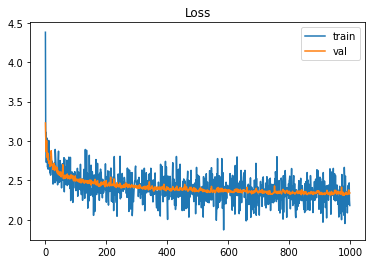

In [480]:
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss")
plt.show()

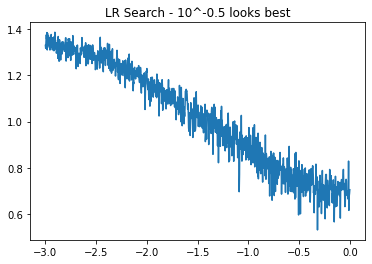

In [397]:
plt.plot(lre, [math.log10(l) for l in lr_losses])
plt.title("LR Search - 10^-0.5 looks best")
plt.show()

In [481]:
# GENERATE NAMES
mlp.generate_words(15, min_length=0, start_chrs=None)

['.avanie.',
 '.mina.',
 '.taydo.',
 '.haliighrynon.',
 '.jlani.',
 '.forala.',
 '.aakylyn.',
 '.quulina.',
 '.anih.',
 '.mmarawi.',
 '.sole.',
 '.kamellayy.',
 '.vie.',
 '.dalajyana.',
 '.relmaella.']

In [353]:
# Measure the test accuracy of predictions following each character & plot
char_acc = dict()
n_preds = dict()
for l in list(stoi.values()):
    tot_samples = 0
    correct = 0
    n_preds[itos[l]] = 0
    inds = torch.where(Xdev == l)[0]
    for sample, label in zip(Xdev[inds], Ydev[inds]):
        tot_samples += 1
        probs, loss = mlp.forward_pass(sample, torch.tensor([label.item()]))
        pred = torch.argmax(probs)
        n_preds[itos[l]] += 1
        if pred.item() == label.item(): correct += 1

    char_acc[itos[l]] = correct/tot_samples

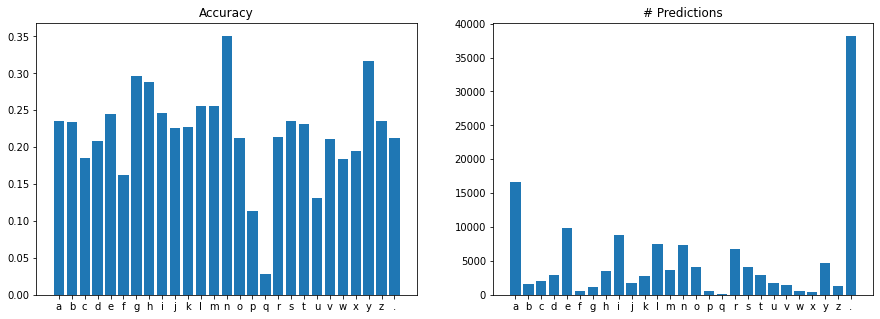

In [354]:
# Test Performance

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].bar(range(len(char_acc)), list(char_acc.values()), align='center')
ax[0].set_xticks(range(len(char_acc)), list(char_acc.keys()))
ax[0].set_title("Accuracy")

ax[1].bar(range(len(n_preds)), list(n_preds.values()), align='center')
ax[1].set_xticks(range(len(n_preds)), list(n_preds.keys()))
ax[1].set_title("# Predictions")


plt.show()